# **CSCI 755: Artificial Intelligence - Final Project**
<h3>Generate Stock Recommendations with Machine Learning Algorithms</h3>

In [12]:
# Group Members:
# Advik Maniar - 1301585
# Biswayan Paul - 1304017
# Reshma Roohi Khayum - 1318671

# Start Date: 4/4/2023

# Description: Develop a WebApp which helps users generate recommendations (buy/hold/sell) for a given stock using various statistical and semantic features using ML algorithms.

# Revision History:
# akm------4/4/2023------Created Basic framework and functions required.
# akm------4/12/2023-----Added functions to extract data from generated stock data and create a DataFrame with the values in real-time.
# akm------4/17/2023-----Added save to CSV functionality.
# akm------4/18/2023-----Added 2 new features to the CSV file (ROE and ROA).
# akm------4/22/2023-----Started working on sentiment analysis column.
# akm------4/24/2023-----Added sentiment analysis column to final dataframe

**Import Libraries**

In [1]:
# General packages
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime as dt
import time
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, HTML

# Yahoo finance API
import yfinance as yf

# Natural Language Processing
import re
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Google Drive
# from google.colab import drive,files
# drive.mount('/content/drive')
location = 'StockData/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reshm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Define Required Functions**

In [ ]:
def f(x):
    display(x)
    return x

def getData(selected_sym):
  # selected_sym=P.result
  # data_price = pd.read_csv(location + selected_sym + '_price_table.csv',encoding="UTF-8")
  # data_hol = pd.read_csv(location + selected_sym + '_hol_table.csv',encoding="UTF-8")
  data_nws = pd.read_csv(location + selected_sym + '_nws_table.csv',encoding="UTF-8")
  # data_rec = pd.read_csv(location + selected_sym + '_rec_table.csv',encoding="UTF-8")
  data_financials = pd.read_csv(location + selected_sym + '_financial_table.csv',encoding="UTF-8")
  # data_balance = pd.read_csv(location + selected_sym + '_balance_table.csv',encoding="UTF-8")
  # data_cashflow = pd.read_csv(location + selected_sym + '_cashflow_table.csv',encoding="UTF-8")
  # data_earnings = pd.read_csv(location + selected_sym + '_earnings_table.csv',encoding="UTF-8")

  return data_nws, data_financials

# P = interactive(f, x=widgets.Dropdown(options=sym_list,value='AAPL',description='Symbol: ',disabled=False))
# print("Select a symbol:")
# display(P)

# Preprocess text data 
def preprocess_text(text):
    
    PS = PorterStemmer()
    text = text.lower() # convert to lowercase
    text = re.sub(r'\d+', '', text) # remove digits
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words] # remove stopwords
    words = [PS.stem(word) for word in words] # perform stemming (reduce a word to its stem)
    return ' '.join(words)

def get_sentiment_score(text):
    SIA = SentimentIntensityAnalyzer()
    return SIA.polarity_scores(text)['compound']

def getSentimentScore(news_data):
  
  # Extract text data from article URLs
  for index, row in news_data.iterrows():
      link = row['link']
      # Retrieve the HTML content of the link with BeautifulSoup and requests
      response = requests.get(link)
      soup = BeautifulSoup(response.content, 'html.parser')
      text = soup.get_text()
      news_data.at[index, 'link_data'] = text

  # Preprocess the text (lowercase, and remove punctuations, digits, and stopwords, and perform stemming)
  news_data['link_data_processed'] = news_data['link_data'].apply(preprocess_text)

  # Sentiment Analysis
  news_data["link_data_score"] = news_data["link_data_processed"].apply(get_sentiment_score)
  score_agg = news_data["link_data_score"].mean()
 
  return score_agg

def getInputFeatures(handle,data_financials):
  # Price of Earning
  pe_ratio = handle.info['trailingPE']
  # Debt-to-equity
  debt_to_equity = data_financials["debtToEquity"].values[0]
  # Book value per share
  book_value_per_share = handle.info['bookValue']
  # Price to book value
  price_to_book_value = handle.info['priceToBook']
  # Recommendation (Observed)
  rec = data_financials["recommendationKey"].values[0]  
  # Return on equity
  roe = data_financials["returnOnEquity"].values[0]
  # Return on assets
  roa = data_financials["returnOnAssets"].values[0]
  # Gross margins
  gross_margin = data_financials["grossMargins"].values[0]
  # Operating margins
  operating_margin = data_financials["operatingMargins"].values[0]

  return pe_ratio, debt_to_equity, book_value_per_share, price_to_book_value, rec, roe, roa, gross_margin, operating_margin

def create_df():

  # Initialize Dataframe
  df = pd.DataFrame()
  sym_list = ['AAPL','GOOG','BLK','META','NKE','ZM','NFLX','DIS','IBM','AMD','EA','TSLA','MSFT','DFS','V','GS','K','NVDA','HMC','VOYA']
  sectors = ["Technology","Technology","Financial Services","Technology","Consumer Cyclical","Technology","Communication Services",
                  "Communication Services","Technology","Technology","Communication Services","Consumer Cyclical","Technology","Financial Services",
                  "Financial Services","Financial Services","Consumer Defensive","Technology","Consumer Cyclical","Financial Services"]
  df["Symbol"] = sym_list
  df["Sector"] = sectors

  pe_ratio_list = []
  debt_to_equity_list = []
  book_value_per_share_list = []
  price_to_book_value_list = []
  rec_list = []
  roe_list = []
  roa_list = []
  gross_margin_list = []
  operating_margin_list = []
  sentiment_score_list = []

  for sym in sym_list:
    data_nws, data_financials = getData(sym)
    handle = yf.Ticker(sym)
    pe_ratio, debt_to_equity, book_value_per_share, price_to_book_value, rec, roe, roa, gross_margin, operating_margin = getInputFeatures(handle,data_financials)
    sentiment_score = getSentimentScore(data_nws)
    pe_ratio_list.append(pe_ratio)
    debt_to_equity_list.append(debt_to_equity)
    book_value_per_share_list.append(book_value_per_share)
    price_to_book_value_list.append(price_to_book_value)
    rec_list.append(rec)
    roe_list.append(roe)
    roa_list.append(roa)
    gross_margin_list.append(gross_margin)
    operating_margin_list.append(operating_margin)
    sentiment_score_list.append(sentiment_score)

  # Final Feature List
  column_names = ['Price_of_Earning',
                  'Debt_To_Equity',
                  'Book_Value_Per_Share',
                  'Price_To_Book_Value',
                  'Sentiment_Score',
                  'Return_On_Equity',
                  'Return_On_Assets',
                  'Gross_margin',
                  'Operating_Margin',
                  'Observed']
  columns_list = [pe_ratio_list,debt_to_equity_list,book_value_per_share_list,price_to_book_value_list,sentiment_score_list,roe_list,roa_list,gross_margin_list,operating_margin_list,rec_list]  
  for i,col in enumerate(column_names):
    df[col] = columns_list[i]    

  return df

# Save dataframe to csv
def saveCSV(name):
  df = create_df()
  df.to_csv(name)

def getFinalData(name):
  saveCSV(name)
  df = pd.read_csv(name,encoding="UTF-8")
  df.drop(["Unnamed: 0"],inplace=True,axis=1)
  return df

def exploratoryDataAnalysis(df):
  # Word Cloud Different sectors in the stock dataset
  # sectors = ' '.join(df['Sector'].astype(str).tolist())
  # wordcloud = WordCloud(random_state = 42).generate(sectors)
  # plt.imshow(wordcloud, interpolation='bilinear')
  # plt.axis("off")
  # plt.show()

  sectors = df["Sector"].value_counts()
  plt.figure(figsize=(12,8))
  sns.barplot(x = sectors.index,y = sectors.values)
  plt.title("Sectors")
  plt.grid()
  plt.show()

  # Correlation Plot
  corr = df.corr(method="pearson")
  plt.figure(figsize=(12,8))
  sns.heatmap(corr, linewidths=2, annot=True)
  plt.title("Pearson correlation between numeric features")
  plt.show()

**Define `main` function**

,Symbol,Sector,Price_of_Earning,Debt_To_Equity,Book_Value_Per_Share,Price_To_Book_Value,Sentiment_Score,Return_On_Equity,Return_On_Assets,Gross_margin,Operating_Margin,Observed
0,AAPL,Technology,28.064627,195.868,3.581,46.082100,0.685275,1.47943,0.19570,0.43059,0.29408,buy
1,GOOG,Technology,23.023914,11.703,19.935,5.312767,0.804812,0.23621,0.12912,0.55379,0.26461,strong_buy
2,BLK,Financial Services,21.094797,21.887,252.036,2.701757,0.817400,0.12858,0.02996,0.49163,0.36250,buy
3,META,Technology,25.104954,21.699,48.092,4.426724,0.579613,0.18516,0.11925,0.79629,0.28776,buy
4,NKE,Consumer Cyclical,36.175793,86.477,9.436,13.303307,0.657700,0.37342,0.10020,0.43851,0.12172,buy
5,ZM,Technology,199.937500,1.554,21.124,3.028782,0.826737,0.01730,0.01957,0.74950,0.05587,hold
6,NFLX,Communication Services,33.812374,81.490,46.654,7.030051,0.730662,0.24528,0.07556,0.39371,0.17817,buy
7,DIS,Communication Services,53.821620,44.432,52.656,1.890953,0.631950,0.03496,0.02065,0.33400,0.07936,buy
8,IBM,Technology,56.129467,245.280,24.218,5.191593,0.917963,0.08689,0.03648,0.54003,0.12501,buy
9,AMD,Technology,105.273810,5.399,33.964,2.603639,0.796325,0.04241,0.01975,0.51061,0.05356,buy


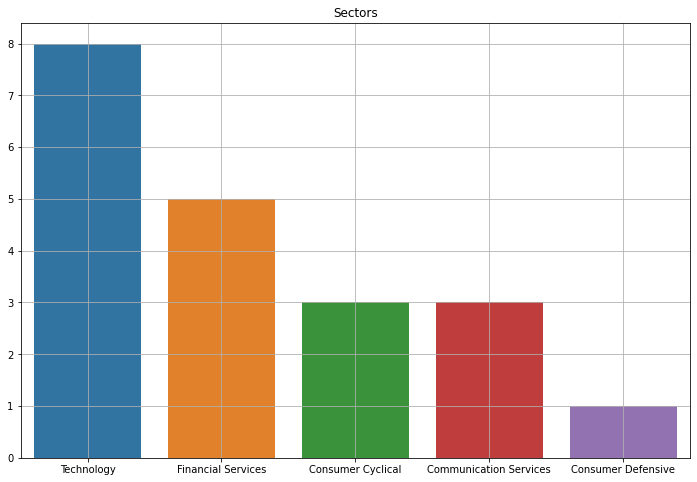

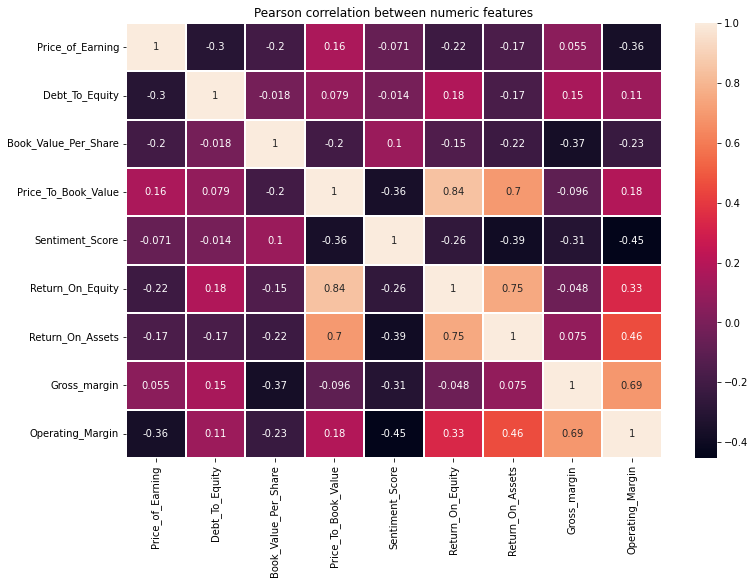




Total Execution Time:  1 minute(s) 5.87 second(s)


In [15]:
def main():
  
  start_time = time.time()

  # Get dataframe for classification
  html_str = "<h2 style='font-size:20px;'>Final Stock Data</h2>"
  display(HTML(html_str))
  df = getFinalData("Stock_Data.csv")
  display(df)

  # Perform simple EDA with final stock dataframe
  html_str = "<h2 style='font-size:20px;'>Exploratory Data Analysis (EDA)</h2>"
  display(HTML(html_str))
  exploratoryDataAnalysis(df)
  
  end_time = time.time()
  return (end_time-start_time)

# Call Main
ex_time = main()
if ex_time > 60:
    print("\n\n\nTotal Execution Time: ",int(ex_time / 60),"minute(s)",round(ex_time % 60, 2), "seconds")
else:
    print("\n\n\nTotal Execution Time: ", round(ex_time, 3), "seconds")

<hr>
<h3>Twitter Data</h3>

In [16]:
# import tweepy

# consumer_key = 'NHoYuZU5hQhKoxtqlrZLcaD78'
# consumer_secret = 'dcNqpEkBtd9XwrtAW27KgoCJqa7jj2OeezAae89Ss1jp3YlHdH'
# access_token = '1470490089042100225-my4LMJR3487slX3Sr2hOyvB1tfs2mj'
# access_token_secret = 'GD0QkIHMDDDkxjIoC6LxCHYjZ8bU1KSd9s0GadeQn1v4i'
# bearer_token = "AAAAAAAAAAAAAAAAAAAAAK04mwEAAAAA65G68lnq381Tj%2BtjYy4ldy8g954%3D8OV7d0vHagosvKuKa11av1iHKzOl84vbYdOon4vIRCO3I5lt1A"


# tweepy_client = tweepy.Client(bearer_token=bearer_token, consumer_key=consumer_key, consumer_secret=consumer_secret,
#                               access_token=access_token, access_token_secret=access_token_secret, wait_on_rate_limit=True)

# def get_today_date_str():
#     today = datetime.datetime.today()
#     today_str = today.strftime("%Y-%m-%d")
#     return today_str

# def get_tweets(keyword):
#     query = f"{keyword} lang:en -is:retweet"
#     tweets = tweepy_client.search_recent_tweets(query=query, tweet_fields=['id', 'created_at', 'text', 'public_metrics'], max_results=10)
#     tweets_df = pd.DataFrame()
#     for tweet in tweets.data:
#         print(f"text {tweet.text}")
#         row = pd.DataFrame({'id': [tweet.id], 'created_at': [tweet.created_at], 'text': [tweet.text], \
#                             'retweet_count': [tweet.public_metrics['retweet_count']], 'reply_count': [tweet.public_metrics['reply_count']], \
#                             'like_count': [tweet.public_metrics['like_count']], 'quote_count': [tweet.public_metrics['quote_count']]})
#         tweets_df = pd.concat([tweets_df, row], axis=0, ignore_index=True)
#     return tweets_df

# get_tweets('AAPL')